# Imports

In [1]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [2]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [3]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [4]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [5]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

## Input/Output

In [6]:
# save a dictionary as a csv file
def output_as_csv(name, a):
    path = "/kaggle/working/" + name + ".csv"
    with open(path, 'w') as csv_file:
        # create the csv writer
        writer = csv.writer(csv_file)

        # write a row to the csv file
        writer.writerow(a.keys())
        writer.writerow(a.values())

# input a csv file
def input_csv(path):
    b, keys = {}, {}
    with open(path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            keys = row
    b = dict(keys)
    return b # returns a dictionary

# Pre-Process DataSet

In [6]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

In [ ]:
# returns the confusion matrix
def find_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_val = y_pred.argmax(axis=1)
    y_test_val = y_test.argmax(axis=1)
    return confusion_matrix(y_test_val, y_pred_val)

# returns the confusion matrix based on tn, fn, fp, tp
def find_confusion_matrix_2(tn, fn, fp, tp):
    return [[tn, fp], [fn, tp]]

# generate heat map for confusion matrix
def heatmap(confusion_matrix):
    df = pd.DataFrame(confusion_matrix, index = ['F', 'T'], columns = ['F', 'T'])
    sn.heatmap(df, annot=True) # create a heatmap
    
# returns normalized confusion matrix
def normalize_confusion_matrix(confusion_matrix):
    confusion_matrix = np.array(confusion_matrix)
    confusion_matrix_sum = confusion_matrix.astype(np.float).sum(axis=1)
    confusion_matrix_norm = confusion_matrix.astype(np.float)
    confusion_matrix_norm[0] = confusion_matrix_norm[0] / confusion_matrix_sum[0]
    confusion_matrix_norm[1] = confusion_matrix_norm[1] / confusion_matrix_sum[1]
    return confusion_matrix_norm

def print_confusion_matrix_results(results):
    # results is a dictionary
    # calculate mean and standard deviation for each key
    for key in results:
        mean = np.mean(results[key])
        std = np.std(results[key])
        print("{} mean: {}".format(key, mean))
        print("{} std: {}".format(key, std))

# Create CNN Model

In [8]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Batch Normalization

In [10]:
# define cnn model
def define_model_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Dropout Regularization

In [ ]:
# define cnn model
def define_model_dropout_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Dropout Regularization and Batch Normalization

In [ ]:
# define cnn model
def define_model_dropout_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2)) # retain 80% of neurons
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [ ]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

### CNN Model with Weight Regularization and Batch Normalization

In [8]:
# define cnn model
def define_model_weight_regularization_batch_normalization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(128, 128, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [ ]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data w/ Cross Validation

In [ ]:
def benchmark_model(X_all, y_all, split):
    X_train_cv, y_train_cv = X_all[split[0]], y_all[split[0]]
    X_val_cv, y_val_cv = X_all[split[1]], y_all[split[1]]
    model, accuracy = train(X_train_cv, X_val_cv, X_val_cv, y_train_cv, y_val_cv, y_val_cv, 0.001, 75) 
    results = {}
    results["model"] = model
    results["accuracy"] = accuracy
    results["confusion_matrix"] = find_confusion_matrix(model, X_val_cv, y_val_cv)
    tn, fp, fn, tp = results["confusion_matrix"].ravel()
    results["tn"] = tn
    results["fp"] = fp
    results["fn"] = fn
    results["tp"] = tp
    results["TPR/Recall"] = tp/(tp+fn)
    results["TNR/Specificity"] = tn/(tn+fp)
    results["PPV/Precision"] = tp/(tp+fp)
    results["NPV"] = tn/(tn+fn)
    return results

In [ ]:
kf = KFold(n_splits=5)
folds = list(kf.split(X_all, y_all))

In [ ]:
output_as_csv("normal_fold_1", benchmark_model(X_all, y_all, folds[0]))

In [ ]:
output_as_csv("normal_fold_2", benchmark_model(X_all, y_all, folds[1]))

In [ ]:
output_as_csv("normal_fold_3", benchmark_model(X_all, y_all, folds[2]))

In [ ]:
output_as_csv("normal_fold_4", benchmark_model(X_all, y_all, folds[3]))

In [ ]:
output_as_csv("normal_fold_5", benchmark_model(X_all, y_all, folds[4]))

In [ ]:
# results_list is a list of dictionaries
results_list = []
for i in range(1,6):
    path = "../input/hurricane-normal-cv/normal_fold_" + str(i) + ".csv"
    results_list.append(input_csv(path))

# results_dict is a dictionary of lists
results_dict = {}
results_dict["accuracy"] = [(float)(i["accuracy"]) for i in results_list]
results_dict["TPR/Recall"] = [(float)(i["TPR/Recall"]) for i in results_list]
results_dict["TNR/Specificity"] = [(float)(i["TNR/Specificity"]) for i in results_list]
results_dict["PPV/Precision"] = [(float)(i["PPV/Precision"]) for i in results_list]
results_dict["NPV"] = [(float)(i["NPV"]) for i in results_list]

print_confusion_matrix_results(results_dict)

In [ ]:
# find confusion matrices
results_dict["tn"] = [(int)(i["tn"]) for i in results_list]
results_dict["fp"] = [(int)(i["fp"]) for i in results_list]
results_dict["fn"] = [(int)(i["fn"]) for i in results_list]
results_dict["tp"] = [(int)(i["tp"]) for i in results_list]
results_dict["confusion_matrix"] = []
# append confusion matrix for each cross-validation fold
for i in range(len(folds)):
    results_dict["confusion_matrix"].append(find_confusion_matrix_2(results_dict["tn"][i], results_dict["fp"][i], results_dict["fn"][i], results_dict["tp"][i]))
                                            
# total confusion matrix summed together
confusion_matrix_list = []
confusion_matrix_list = results_dict["confusion_matrix"]
confusion_matrix_comb = np.sum(confusion_matrix_list, axis=0)
heatmap(confusion_matrix_comb)

In [ ]:
# normalized confusion matrix
confusion_matrix_norm = normalize_confusion_matrix(confusion_matrix_comb)
heatmap(confusion_matrix_norm)

## Train Data with Batch Normalization

In [11]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Tune Hyperparameters - learning rate

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.0005, 75)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.01, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.1, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Tune Hyperparameters - batch size

In [12]:
def train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, batch_size, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 128, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
313/313 [==============================] - 798s 3s/step - loss: 0.2936 - accuracy: 0.8899 - val_loss: 2.4919 - val_accuracy: 0.5320
Epoch 2/40
313/313 [==============================] - 794s 3s/step - loss: 0.1251 - accuracy: 0.9495 - val_loss: 0.9957 - val_accuracy: 0.5765
Epoch 3/40
313/313 [==============================] - 796s 3s/step - loss: 0.0804 - accuracy: 0.9700 - val_loss: 2.4555 - val_accuracy: 0.5100
Epoch 4/40
313/313 [==============================] - 795s 3s/step - loss: 0.0604 - accuracy: 0.9783 - val_loss: 0.1650 - val_accuracy: 0.9415
Epoch 5/40
313/313 [==============================] - 795s 3s/step - loss: 0.0442 - accuracy: 0.9846 - val_loss: 0.1404 - val_accuracy: 0.9555
Epoch 6/40
313/313 [==============================] - 801s 3s/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 0.1840 - val_accuracy: 0.9370
Epoch 7/40
313/313 [==============================] - 798s 3s/step - loss: 0.0201 - accuracy: 0.9949 - val_loss: 0.1267 - val_accuracy: 0.9560

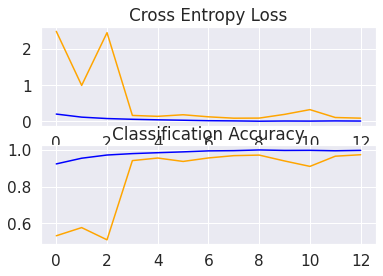

In [13]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 32, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
40/40 [==============================] - 824s 21s/step - loss: 0.4255 - accuracy: 0.8305 - val_loss: 1.2056 - val_accuracy: 0.5000
Epoch 2/40
40/40 [==============================] - 824s 21s/step - loss: 0.1241 - accuracy: 0.9522 - val_loss: 1.7430 - val_accuracy: 0.5000
Epoch 3/40
40/40 [==============================] - 821s 21s/step - loss: 0.1054 - accuracy: 0.9601 - val_loss: 2.4345 - val_accuracy: 0.5000
Epoch 4/40
40/40 [==============================] - 820s 21s/step - loss: 0.0769 - accuracy: 0.9743 - val_loss: 2.5078 - val_accuracy: 0.5000
Epoch 5/40
40/40 [==============================] - 821s 21s/step - loss: 0.0639 - accuracy: 0.9813 - val_loss: 2.3492 - val_accuracy: 0.4995
Epoch 6/40
40/40 [==============================] - 822s 21s/step - loss: 0.0484 - accuracy: 0.9859 - val_loss: 2.4154 - val_accuracy: 0.5000
Epoch 00006: early stopping
63/63 [==============================] - 36s 566ms/step - loss: 2.4074 - accuracy: 0.4995
0.49950000643730164
7 993 8 99

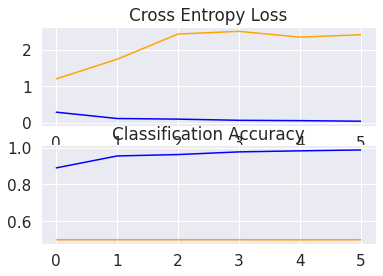

In [14]:
model_test_batch_normalization, accuracy = train_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.005, 256, 40)
print(accuracy)
y_pred = model_test_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Batch Normalization and Cross Validation 

In [ ]:
def benchmark_model_batch_normalization(X_all, y_all, split):
    X_train_cv, y_train_cv = X_all[split[0]], y_all[split[0]]
    X_val_cv, y_val_cv = X_all[split[1]], y_all[split[1]]
    model, accuracy = train_batch_normalization(X_train_cv, X_val_cv, X_val_cv, y_train_cv, y_val_cv, y_val_cv, 0.001, 75) 
    results = {}
    results["model"] = model
    results["accuracy"] = accuracy
    results["confusion_matrix"] = find_confusion_matrix(model, X_val_cv, y_val_cv)
    tn, fp, fn, tp = results["confusion_matrix"].ravel()
    results["tn"] = tn
    results["fp"] = fp
    results["fn"] = fn
    results["tp"] = tp
    results["TPR/Recall"] = tp/(tp+fn)
    results["TNR/Specificity"] = tn/(tn+fp)
    results["PPV/Precision"] = tp/(tp+fp)
    results["NPV"] = tn/(tn+fn)
    return results

In [ ]:
kf = KFold(n_splits=5)
folds = list(kf.split(X_all, y_all))

In [ ]:
output_as_csv("batch normalization fold 1", benchmark_model_batch_normalization(X_all, y_all, folds[0]))

In [ ]:
output_as_csv("batch normalization fold 2", benchmark_model_batch_normalization(X_all, y_all, folds[1]))

In [ ]:
output_as_csv("batch normalization fold 3", benchmark_model_batch_normalization(X_all, y_all, folds[2]))

In [ ]:
output_as_csv("batch normalization fold 4", benchmark_model_batch_normalization(X_all, y_all, folds[3]))

In [ ]:
output_as_csv("batch normalization fold 5", benchmark_model_batch_normalization(X_all, y_all, folds[4]))

## Train Data with Data Augmentation

In [ ]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=8, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 50)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation and Batch Normalization

In [ ]:
def train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)

In [ ]:
model_test_data_augmentation_batch_normalization, accuracy = train_data_augmentation_batch_normalization(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 100)
print(accuracy)
y_pred = model_test_data_augmentation_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Dropout Regularization and Batch Normalization

In [ ]:
def train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_dropout_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_dropout_batch_normalization, accuracy = train_data_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 40)
print(accuracy)
y_pred = model_test_data_dropout_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation, Dropout Regularization and Batch Normalization

In [ ]:
def train_data_augmentation_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_dropout_batch_normalization, accuracy = train_data_augmentation_dropout_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 25)
print(accuracy)
y_pred = model_test_data_dropout_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization and Batch Normalization

In [9]:
def train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
157/157 [==============================] - 677s 4s/step - loss: 10.5523 - accuracy: 0.8847 - val_loss: 12.0627 - val_accuracy: 0.5000
Epoch 2/40
157/157 [==============================] - 680s 4s/step - loss: 5.6298 - accuracy: 0.9560 - val_loss: 7.6386 - val_accuracy: 0.5000
Epoch 3/40
157/157 [==============================] - 678s 4s/step - loss: 3.0370 - accuracy: 0.9635 - val_loss: 3.2918 - val_accuracy: 0.5000
Epoch 4/40
157/157 [==============================] - 679s 4s/step - loss: 1.6792 - accuracy: 0.9666 - val_loss: 1.8274 - val_accuracy: 0.7270
Epoch 5/40
157/157 [==============================] - 677s 4s/step - loss: 0.9706 - accuracy: 0.9662 - val_loss: 3.9047 - val_accuracy: 0.5000
Epoch 6/40
157/157 [==============================] - 671s 4s/step - loss: 0.6059 - accuracy: 0.9669 - val_loss: 2.3120 - val_accuracy: 0.5000
Epoch 7/40
157/157 [==============================] - 674s 4s/step - loss: 0.4302 - accuracy: 0.9613 - val_loss: 0.7479 - val_accuracy: 0.81

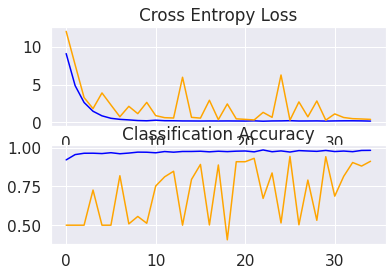

In [11]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.01, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
157/157 [==============================] - 743s 5s/step - loss: 11.4023 - accuracy: 0.8759 - val_loss: 15.0432 - val_accuracy: 0.5000
Epoch 2/40
157/157 [==============================] - 734s 5s/step - loss: 9.3011 - accuracy: 0.9628 - val_loss: 11.4790 - val_accuracy: 0.5035
Epoch 3/40
157/157 [==============================] - 735s 5s/step - loss: 7.6950 - accuracy: 0.9736 - val_loss: 8.5591 - val_accuracy: 0.5570
Epoch 4/40
157/157 [==============================] - 734s 5s/step - loss: 6.3760 - accuracy: 0.9796 - val_loss: 5.9075 - val_accuracy: 0.8335
Epoch 5/40
157/157 [==============================] - 737s 5s/step - loss: 5.2721 - accuracy: 0.9881 - val_loss: 4.9606 - val_accuracy: 0.8205
Epoch 6/40
157/157 [==============================] - 736s 5s/step - loss: 4.3750 - accuracy: 0.9889 - val_loss: 3.8860 - val_accuracy: 0.9565
Epoch 7/40
157/157 [==============================] - 732s 5s/step - loss: 3.6253 - accuracy: 0.9928 - val_loss: 3.3477 - val_accuracy: 0.9

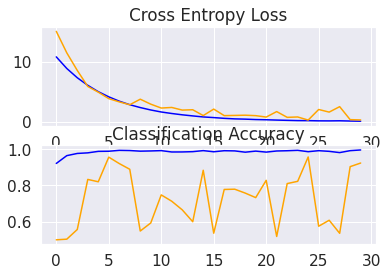

In [11]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.003, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
157/157 [==============================] - 703s 4s/step - loss: 11.5109 - accuracy: 0.8801 - val_loss: 13.8733 - val_accuracy: 0.5000
Epoch 2/40
157/157 [==============================] - 694s 4s/step - loss: 9.9923 - accuracy: 0.9690 - val_loss: 10.1518 - val_accuracy: 0.5320
Epoch 3/40
157/157 [==============================] - 692s 4s/step - loss: 8.7921 - accuracy: 0.9844 - val_loss: 9.2564 - val_accuracy: 0.5800
Epoch 4/40
157/157 [==============================] - 694s 4s/step - loss: 7.7476 - accuracy: 0.9895 - val_loss: 7.5302 - val_accuracy: 0.7765
Epoch 5/40
157/157 [==============================] - 697s 4s/step - loss: 6.8252 - accuracy: 0.9938 - val_loss: 6.3100 - val_accuracy: 0.9500
Epoch 6/40
157/157 [==============================] - 696s 4s/step - loss: 6.0111 - accuracy: 0.9975 - val_loss: 5.6095 - val_accuracy: 0.9395
Epoch 7/40
157/157 [==============================] - 696s 4s/step - loss: 5.2978 - accuracy: 0.9987 - val_loss: 5.0102 - val_accuracy: 0.9

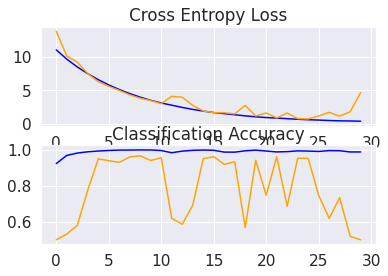

In [10]:
model_test_weight_batch_normalization, accuracy = train_data_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.002, 40)
print(accuracy)
y_pred = model_test_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation, Weight Regularization and Batch Normalization

In [10]:
def train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization_batch_normalization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_weight_batch_normalization, accuracy = train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 30)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
156/156 [==============================] - 784s 5s/step - loss: 10.5983 - accuracy: 0.8775 - val_loss: 14.3022 - val_accuracy: 0.5000
Epoch 2/40
156/156 [==============================] - 772s 5s/step - loss: 5.7000 - accuracy: 0.9497 - val_loss: 9.6794 - val_accuracy: 0.5000
Epoch 3/40
156/156 [==============================] - 763s 5s/step - loss: 3.1153 - accuracy: 0.9412 - val_loss: 5.5012 - val_accuracy: 0.5000
Epoch 4/40
156/156 [==============================] - 761s 5s/step - loss: 1.7469 - accuracy: 0.9461 - val_loss: 1.7801 - val_accuracy: 0.8490
Epoch 5/40
156/156 [==============================] - 790s 5s/step - loss: 1.0350 - accuracy: 0.9480 - val_loss: 3.4242 - val_accuracy: 0.5190
Epoch 6/40
156/156 [==============================] - 774s 5s/step - loss: 0.6451 - accuracy: 0.9454 - val_loss: 1.1490 - val_accuracy: 0.4275
Epoch 7/40
156/156 [==============================] - 782s 5s/step - loss: 0.4379 - accuracy: 0.9530 - val_loss: 1.8987 - val_accuracy: 0.49

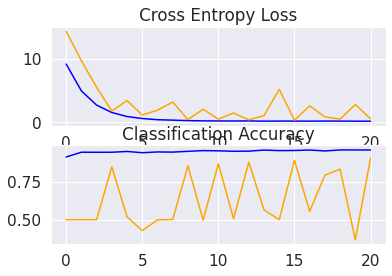

In [11]:
model_test_data_weight_batch_normalization, accuracy = train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.01, 40)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/40
156/156 [==============================] - 710s 5s/step - loss: 11.4673 - accuracy: 0.8753 - val_loss: 12.4760 - val_accuracy: 0.5000
Epoch 2/40
156/156 [==============================] - 707s 5s/step - loss: 9.3965 - accuracy: 0.9514 - val_loss: 11.6465 - val_accuracy: 0.5000
Epoch 3/40
156/156 [==============================] - 705s 5s/step - loss: 7.8025 - accuracy: 0.9533 - val_loss: 8.0653 - val_accuracy: 0.5565
Epoch 4/40
156/156 [==============================] - 707s 5s/step - loss: 6.4751 - accuracy: 0.9603 - val_loss: 5.8448 - val_accuracy: 0.8700
Epoch 5/40
156/156 [==============================] - 706s 5s/step - loss: 5.3812 - accuracy: 0.9645 - val_loss: 5.1852 - val_accuracy: 0.6890
Epoch 6/40
156/156 [==============================] - 716s 5s/step - loss: 4.4759 - accuracy: 0.9651 - val_loss: 4.0971 - val_accuracy: 0.8825
Epoch 7/40
156/156 [==============================] - 708s 5s/step - loss: 3.7287 - accuracy: 0.9678 - val_loss: 4.2868 - val_accuracy: 0.7

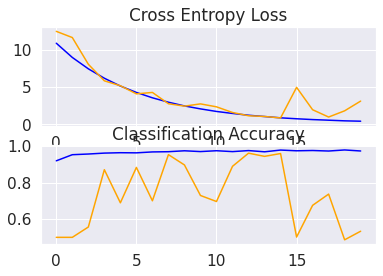

In [11]:
model_test_data_weight_batch_normalization, accuracy = train_data_augmentation_weight_batch(X_train, X_val, X_test, y_train, y_val, y_test, 0.003, 40)
print(accuracy)
y_pred = model_test_data_weight_batch_normalization.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))